In [1]:
cd /Users/cl1704/PycharmProjects/clustering_in_rnns

/Users/cl1704/PycharmProjects/clustering_in_rnns


In [2]:

from Experiment_2.TwoAFCTask import generate_trials
#from Experiment_5.SiegelMillerTask import generate_trials
import networkx as nx
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
from Experiment_2.net import *
import os
import statsmodels.api as sm
import scipy.optimize as opt
import math
#from psychometrics import *
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans

plt.rcParams["axes.grid"] = False
from sklearn.manifold import TSNE

matplotlib.rcParams['axes.linewidth'] = .5


def compute_var(variance, n):
    return np.sum(variance[n:])


def compute_p(k, null_k):
    return np.sum(null_k < k) / len(null_k)

IndexError: index 0 is out of bounds for axis 0 with size 0

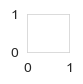

In [4]:
df_list = []
for filename in os.listdir('Experiment_2/Results_2'):
    f = os.path.join('Experiment_2/Results_2', filename)
    if os.path.isfile(f):
        df_list.append(pd.read_pickle(f))
original_df = pd.concat(df_list,ignore_index=True) 
original_df = original_df[original_df.mse_z<.035]
original_df = original_df[original_df.lambda_std==0.1]
original_df = original_df[original_df.sigma_rec==0.]

# Trial data for simulations
u, z, mask, conditions  = generate_trials(
                                    n_trials=100)
palette = sns.color_palette("husl", n_colors=75,as_cmap=False)


fig = plt.figure(figsize=(7,.5))
gs = gridspec.GridSpec(1,9,wspace = .5)

# Load data for row
df =original_df.copy()

k = 3
df  = df[df.dim==k]
#df = df[df.k>=dim]
df['k_inertia'] = df.inertia.apply(lambda x: x[k-1])
df['var'] = df.variance.apply(lambda x: compute_var(x,k))
df['var'] = np.log(df['var'])
df = df.sort_values('var',ascending=True)
#bins = np.linspace(-3,-.75,9)

# 
# df['bin'] = pd.cut(df['var'],bins=bins)
# df['mean'] = df.bin.apply(lambda x: np.mean([x.left,x.right]))
# df['mean'] = df['mean'].astype(float).round(3)
# bin_means = np.sort(df['mean'].unique())
idx = [13282,13487,13324,10156,10318,13868,6643,5399,2306]

#bins = [0,.025,.05,.1,.2,.3,.4,.5,.6]
for col in range(9):
    # Create axis
    ax=fig.add_subplot(gs[0,col])
    # Load model data for column
    
    model_id = df[df.index==idx[col]].model_id.values[0]
    #model_id  = df[ (df['mean'] ==bin_means[col] )].sort_values('var')['model_id'].values[1]
    model_data = df[df.model_id==model_id]

    # Simulate model
    net = Net(n=100,input_size = 2,dale=False)
    net.recurrent_layer.weight.data = torch.tensor(model_data['w_rec'].item())
    net.recurrent_layer.bias.data = torch.tensor(model_data['bias'].item())
    net.input_layer.weight.data = torch.tensor(model_data['w_in'].item())
    net.output_layer.weight.data = torch.tensor(model_data['w_out'].item())
    palette = sns.color_palette("husl", n_colors=75,as_cmap=False)
    x = net(u)

    pca = PCA()
    pca.fit(x[:,:,:].detach().numpy().reshape(-1, x.shape[2]))
    x_proj = pca.transform(x.detach().numpy().reshape(-1, x.shape[2])).reshape(x.shape[0],x.shape[1],x.shape[2])
    rows = []
    for k in range(u.shape[0]):
        for t in range(u.shape[1]):
            rows.append({'trial':k,
                         'motion':conditions[k]['motion_coh'],
                        't':t,
                        'z_1':x_proj[k,t,0],
                        'z_2':x_proj[k,t,1],
                         'z_3':x_proj[k,t,2]})
    new_df = pd.DataFrame(rows)
    new_df_mean =new_df.groupby(['motion','t']).mean().reset_index()
    sns.scatterplot(data=new_df_mean,x='z_1',y='z_2',hue='t',ax=ax,legend=False,s=2,alpha=.5,palette = palette,edgecolor=None)
    
    # Make axis pretty
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_xlabel("PC 1",fontsize=6)
    ax.set_ylabel("PC 2",fontsize=6)
    #ax.set_title(r'$\sum_{i\geq 2}\lambda_i = $'+str(np.round(variance,4)),fontsize=8)
    ax.xaxis.set_tick_params(labelsize=6,bottom=False)
    ax.yaxis.set_tick_params(labelsize=6,left=False)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
 #    if row ==0:
     #        ax.text(.5,-.2,r'$\sum_{i>2}\lambda_i=$'+' '+str(np.round(np.sum(pca.explained_variance_ratio_[row+2:]),3)), horizontalalignment='center',
     # verticalalignment='center', transform=ax.transAxes,fontsize = 4)
     #    if row ==1:
     #        ax.text(.5,-.2,r'$\sum_{i>3}\lambda_i=$'+' '+str(np.round(np.sum(pca.explained_variance_ratio_[row+2:]),3)), horizontalalignment='center',
     # verticalalignment='center', transform=ax.transAxes,fontsize = 4)
     #    if row == 2:
     #        ax.text(.5,-.2,r'$\sum_{i>4}\lambda_i=$'+' '+str(np.round(np.sum(pca.explained_variance_ratio_[row+2:]),3)), horizontalalignment='center',
     # verticalalignment='center', transform=ax.transAxes,fontsize = 4)
        
fig.savefig('Figures/SIFig_2afcmanifolds.jpg',
    format='jpeg',
    dpi=450,
            bbox_inches='tight')
